Importing Libraries

In [ ]:
import pandas as pd
import networkx as nx
import pyarrow.parquet as pq
from functools import reduce
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, mean_absolute_percentage_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
import country_converter as coco
import torch
from torch_geometric.data import Data
import functools
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor7
import os

# Set up device (is available use GPU to speed up computations)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

os.chdir('/home/jovyan/dlss-project')
print("Current working directory:", os.getcwd())

Data Loading + Pre-Processing

In [ ]:
path_geo_edges = "data_collection/geography/edges_yearly_dist_enc.parquet"
path_geo_nodes = "data_collection/geography/nodes_enc.parquet"
df_geo_edges = pd.read_parquet(path_geo_edges)
df_geo_nodes = pd.read_parquet(path_geo_nodes)

path_pol_edges = "data_collection/political/data/edge_features.parquet"
path_pol_nodes = "data_collection/political/data/node_features.parquet"
df_pol_edges = pd.read_parquet(path_pol_edges)
df_pol_nodes = pd.read_parquet(path_pol_nodes)

path_cult_edges = "data_collection/culture/culture_edges.parquet"
path_cult_nodes = "data_collection/culture/culture_nodes.parquet"
df_cult_edges = pd.read_parquet(path_cult_edges)
df_cult_nodes = pd.read_parquet(path_cult_nodes)

path_lang_edges = "data_collection/culture/language_religion_edges.parquet"
path_lang_nodes = "data_collection/culture/language_religion_nodes.parquet"
df_lang_edges = pd.read_parquet(path_lang_edges)
df_lang_nodes = pd.read_parquet(path_lang_nodes)

path_eco_edges = "data_collection/economics/edges_economics.parquet"
path_eco_nodes = "data_collection/economics/nodes_economics.parquet"
df_eco_edges = pd.read_parquet(path_eco_edges)
df_eco_nodes = pd.read_parquet(path_eco_nodes)

df_gini=pd.read_parquet("data_collection/gini.parquet")

In [539]:
@functools.lru_cache(maxsize=1)
def get_un_countries():
    """Cache UN member countries to avoid repeated lookups"""
    iso3 = coco.CountryConverter().data[coco.CountryConverter().data['UNmember'].notna()]['ISO3'].dropna().tolist()
    unnumeric = coco.CountryConverter().data[coco.CountryConverter().data['UNmember'].notna()]['UNcode'].dropna().tolist()
    return iso3, unnumeric

@functools.lru_cache(maxsize=1000)
def convert_country_code(country, target_format='UNnumeric'):
    """Cache country code conversions"""
    return coco.convert(names=country, to=target_format, not_found=None)

def df_preparation(edge_df, node_df, edge_country_a_col, edge_country_b_col, node_country_col, year_col="year"):
    # Get UN countries once
    uno_iso3_codes, uno_unnumeric_codes = get_un_countries()

    # Pre-filter dataframes
    edge_mask = edge_df[edge_country_a_col].isin(uno_iso3_codes) & edge_df[edge_country_b_col].isin(uno_iso3_codes)
    node_mask = node_df[node_country_col].isin(uno_iso3_codes)

    edge_df = edge_df[edge_mask].copy()
    node_df = node_df[node_mask].copy()

    # Ensure year is int before unique extraction
    edge_df[year_col] = edge_df[year_col].astype(int)
    node_df[year_col] = node_df[year_col].astype(int)

    # Vectorized country code conversion
    unique_countries_edges = pd.concat([edge_df[edge_country_a_col], edge_df[edge_country_b_col]]).unique()
    unique_countries_nodes = node_df[node_country_col].unique()
    all_unique_countries = np.unique(np.concatenate([unique_countries_edges, unique_countries_nodes]))

    country_to_id_map = dict(zip(
        all_unique_countries,
        coco.convert(all_unique_countries.tolist(), to='UNnumeric', not_found=None)
    ))

    # Apply mapping
    edge_df['country_id_a'] = edge_df[edge_country_a_col].map(country_to_id_map)
    edge_df['country_id_b'] = edge_df[edge_country_b_col].map(country_to_id_map)
    node_df['country_id'] = node_df[node_country_col].map(country_to_id_map)

    # Drop any rows where mapping failed (shouldn't if filters were correct)
    edge_df = edge_df.dropna(subset=['country_id_a', 'country_id_b'])
    node_df = node_df.dropna(subset=['country_id'])

    # Cast country_id to int
    edge_df['country_id_a'] = edge_df['country_id_a'].astype(int)
    edge_df['country_id_b'] = edge_df['country_id_b'].astype(int)
    node_df['country_id'] = node_df['country_id'].astype(int)
    
    edge_features_cols = [
        col for col in edge_df.columns
        if col not in [edge_country_a_col, edge_country_b_col, year_col, 'country_id_a', 'country_id_b']
    ]
    node_features_cols = [
        col for col in node_df.columns
        if col not in [node_country_col, year_col, 'country_id']
    ]
    
    edge_df_processed = edge_df.copy()[['country_id_a', 'country_id_b', year_col] + edge_features_cols]
    node_df_processed = node_df.copy()[['country_id', year_col] + node_features_cols]
    
    return node_df_processed, edge_df_processed

def preprocess_gini(df_gini, year_col='year', country_col='country', gini_col='gini'):
    uno_iso3_codes, uno_unnumeric_codes = get_un_countries()

    # Filter Gini data for UN countries
    df_gini = df_gini[df_gini[country_col].isin(uno_iso3_codes)].copy()
    
    # Convert country codes to UN numeric
    df_gini['country_id'] = df_gini[country_col].map(lambda x: convert_country_code(x, 'UNnumeric'))
    
    df_gini = df_gini.sort_values(by=['country_id']).reset_index(drop=True)
    
    # Drop rows with NaN country_id
    df_gini = df_gini.dropna(subset=['country_id'])
    
    # Normalize Gini values to [0, 1] range for each year
    df_gini[gini_col] = df_gini[gini_col] / 100
    
    # create mask column to indicate if country exists in this year
    df_gini['exists'] = 1
    df_gini.loc[df_gini[gini_col].isna(), 'exists'] = 0
    
    df_gini.loc[df_gini[gini_col].isna(), gini_col] = 0  # Fill NaN Gini values with 0
    
    return df_gini[['country_id', year_col, gini_col, 'exists']].copy()

def create_data_yearly(node_df, edge_df, year, mask_col, year_col='year',):
        
    edge_df_year = edge_df[edge_df[year_col] == year]
    node_df_year = node_df[node_df[year_col] == year].copy()  # copy because we'll potentially modify
    
    # drop dupicate rows in node_df_year
    node_df_year = node_df_year.drop_duplicates(subset=['country_id', year_col], keep='first')
            
    # --- Edge features ---
    edge_features_cols = [
        col for col in edge_df_year.columns
        if col not in ['country_id_a', 'country_id_b', year_col]
    ]
    edge_features_df = edge_df_year[edge_features_cols].copy()
    
    # Coerce all edge feature columns to numeric, fill NaN with 0
    edge_features_df = edge_features_df.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    # --- Node features ---
    node_features_cols = [
        col for col in node_df_year.columns
        if col not in ['country_id', year_col, mask_col]
    ]
    # TODO: maybe also remove 'exists' column
        
    # Ensure node_df_year is sorted by country_id and align features accordingly
    node_df_year_sorted = node_df_year.sort_values(by='country_id').reset_index(drop=True)
        
    # select only feature columns
    node_df_year_features = node_df_year_sorted[node_features_cols].copy()
    
    mask_col_tensor = torch.tensor(node_df_year_sorted[mask_col].values, dtype=torch.float32)
    
    country_id_tensor = torch.tensor(node_df_year_sorted['country_id'].values, dtype=torch.long)
    
    # --- Tensor creation ---
    edge_features_array = edge_features_df.values.astype(np.float32)
    edge_attr = torch.from_numpy(edge_features_array)

    
    node_df_year_features = node_df_year_features.apply(pd.to_numeric, errors='coerce').fillna(0)
    node_features_tensor = torch.tensor(node_df_year_features.values, dtype=torch.float32)
    
    
    # Build a mapping from country_id to its position in the sorted node list
    country_id_to_pos = {cid: i for i, cid in enumerate(node_df_year_sorted['country_id'].values)}
    
    # Map edge indices to positions in the sorted node list
    edge_index = torch.tensor(
        [
        edge_df_year['country_id_a'].map(country_id_to_pos).values,
        edge_df_year['country_id_b'].map(country_id_to_pos).values
        ],
        dtype=torch.long
    )
    data = Data(x=node_features_tensor, edge_index=edge_index, edge_attr=edge_attr, country_id = country_id_tensor, mask=mask_col_tensor)
    
    return data

def scale_data(node_df, edge_df, node_features_cols, edge_feature_cols):
    """
    Scale node and edge dataframes using StandardScaler.
    """
    # apply standardization to node features
    node_scaler = StandardScaler()
    edge_scaler = StandardScaler()
    
    # fit standard scaler on train set
    
    # create subset of only training rows to fit scaler
    node_df_train_subset = node_df[node_df['train_mask'] == 1]
    node_scaler.fit(node_df_train_subset[node_features_cols])
    
    # filter edge_df to only include training countries
    edge_df_train_subset = edge_df[edge_df['country_id_a'].isin(node_df_train_subset['country_id']) & 
                                   edge_df['country_id_b'].isin(node_df_train_subset['country_id'])]
    edge_scaler.fit(edge_df_train_subset[edge_feature_cols])
    
    # apply scaler to all node dataframes
    node_df[node_features_cols] = node_scaler.transform(node_df[node_features_cols])
    edge_df[edge_feature_cols] = edge_scaler.transform(edge_df[edge_feature_cols])
    
    return node_df, edge_df

def create_network_data(node_df, edge_df, gini_df):
    uno_iso3_codes, uno_unnumeric_codes = get_un_countries()
    
    # convert boolean columns to int
    bool_cols_nodes = node_df.select_dtypes(include='bool').columns
    if len(bool_cols_nodes) > 0:
        node_df[bool_cols_nodes] = node_df[bool_cols_nodes].astype(int)
    bool_cols_edges = edge_df.select_dtypes(include='bool').columns
    if len(bool_cols_edges) > 0:
        edge_df[bool_cols_edges] = edge_df[bool_cols_edges].astype(int)
    
    # fill in all missing countries with 0 values for the years from 2000 to 2022
    all_years = range(2000, 2023)
    all_countries = uno_unnumeric_codes
    
    # Create a MultiIndex of all combinations
    full_index = pd.MultiIndex.from_product([all_countries, all_years], names=['country_id', 'year'])
    node_df = node_df.set_index(['country_id', 'year'])
    node_df = node_df.reindex(full_index, fill_value=0).reset_index()
        
    # Fill missing feature columns with 0 (if any NaNs)
    node_features_cols = [col for col in node_df.columns if col not in ['country_id', 'year']]
    node_df[node_features_cols] = node_df[node_features_cols].fillna(0)
    
    edge_feature_cols = [col for col in edge_df.columns if col not in ['country_id_a', 'country_id_b', 'year']]
    
    # merge node_df with gini_df
    node_df_merged = node_df.merge(gini_df, on=['country_id', 'year'])
    
    node_df_merged, edge_df = scale_data(node_df_merged, edge_df, node_features_cols, edge_feature_cols)
    
    # generate train, val and test set.
    # set gini to 0 at respected masks
    
    node_df_train = node_df_merged.copy().drop(columns=['val_mask', 'test_mask'], errors='ignore')
    node_df_val = node_df_merged.copy().drop(columns=['train_mask', 'test_mask'], errors='ignore')
    node_df_test = node_df_merged.copy().drop(columns=['train_mask', 'val_mask'], errors='ignore')
    
    # set gini to 0 where train_mask is 1
    node_df_train.loc[gini_df['train_mask'] == 1, 'gini'] = 0
    node_df_val.loc[gini_df['val_mask'] == 1, 'gini'] = 0
    node_df_test.loc[gini_df['test_mask'] == 1, 'gini'] = 0
    
    
    # limit years from 2000 to 2022
    years = [year for year in range(2000, 2023)]
    
    data_dict = {}
    # create data for each year
    
    for year in years:
        data_train = create_data_yearly(node_df_train, edge_df, year, 'train_mask', year_col='year')
        data_val = create_data_yearly(node_df_val, edge_df, year, 'val_mask', year_col='year')
        data_test = create_data_yearly(node_df_test, edge_df, year, 'test_mask', year_col='year')
        data_dict[year] = {
            'train': data_train,
            'val': data_val,
            'test': data_test
        }
    
    return data_dict

def create_gini_data(gini_df, year_col='year'):
    
    gini_dict = {}
    
    for year in range(2000, 2023):
        gini_df_year = gini_df[gini_df[year_col] == year].copy()

        # convert to tensor
        gini_tensor = torch.tensor(gini_df_year['gini'].values, dtype=torch.float32)
        country_id_tensor = torch.tensor(gini_df_year['country_id'].values, dtype=torch.long)
        train_mask_tensor = torch.tensor(gini_df_year['train_mask'].values, dtype=torch.bool)
        val_mask_tensor = torch.tensor(gini_df_year['val_mask'].values, dtype=torch.bool)
        test_mask_tensor = torch.tensor(gini_df_year['test_mask'].values, dtype=torch.bool)
        
        
        
        gini_dict[year] = {
            'train': Data(y=gini_tensor.unsqueeze(1), country_id=country_id_tensor, mask=train_mask_tensor),
            'val': Data(y=gini_tensor.unsqueeze(1), country_id=country_id_tensor, mask=val_mask_tensor),
            'test': Data(y=gini_tensor.unsqueeze(1), country_id=country_id_tensor, mask=test_mask_tensor)
        }
        
    return gini_dict
            

def create_global_gini_masks(gini_df, test_size=0.2, val_size=0.2, random_state=42):
    """
    Split all available (exists==1) rows in gini_df into train/val/test and create mask columns.
    Adds 'train_mask', 'val_mask', 'test_mask' columns to gini_df (0/1 values).
    """
    df = gini_df.copy()
    available_idx = df.index[df['exists'] == 1].tolist()
    train_idx, test_idx = train_test_split(available_idx, test_size=test_size, random_state=random_state)
    train_idx, val_idx = train_test_split(train_idx, test_size=val_size, random_state=random_state)
    
    df['train_mask'] = 0
    df['val_mask'] = 0
    df['test_mask'] = 0
    df.loc[train_idx, 'train_mask'] = 1
    df.loc[val_idx, 'val_mask'] = 1
    df.loc[test_idx, 'test_mask'] = 1
    return df

def create_data(data_combined, gini_df):
    
    # create gini train, val and test masks
    # perform train-val-test split on gini_data for all available values
    
    gini_df = create_global_gini_masks(gini_df, test_size=0.2, val_size=0.2, random_state=42)
    
    data_dict = {}
    
    for modality, data in data_combined.items():
        nodes = data['nodes']
        edges = data['edges']
        data_dict[modality] = create_network_data(nodes, edges, gini_df)
        
    # add gini data
    gini_data = create_gini_data(gini_df)
    data_dict['gini'] = gini_data
    
    data_dict_reform = {}
    # reform data_dict to have years as keys
    for year in range(2000, 2023):
        data_dict_reform[year] = {
            'political': data_dict['political'][year],
            'geography': data_dict['geography'][year],
            'culture': data_dict['culture'][year],
            'language': data_dict['language'][year],
            'economy': data_dict['economy'][year],
            'gini': gini_data[year]
        }
    
    # reform again to have train, val, test as subkeys -> data_dict_reform[year]['train'], data_dict_reform[year]['val'], data_dict_reform[year]['test']
    for year in data_dict_reform.keys():
        data_dict_reform[year] = {
            'train': {
                'political': data_dict_reform[year]['political']['train'],
                'geography': data_dict_reform[year]['geography']['train'],
                'culture': data_dict_reform[year]['culture']['train'],
                'language': data_dict_reform[year]['language']['train'],
                'economy': data_dict_reform[year]['economy']['train'],
                'gini': data_dict_reform[year]['gini']['train']
            },
            'val': {
                'political': data_dict_reform[year]['political']['val'],
                'geography': data_dict_reform[year]['geography']['val'],
                'culture': data_dict_reform[year]['culture']['val'],
                'language': data_dict_reform[year]['language']['val'],
                'economy': data_dict_reform[year]['economy']['val'],
                'gini': data_dict_reform[year]['gini']['val']
            },
            'test': {
                'political': data_dict_reform[year]['political']['test'],
                'geography': data_dict_reform[year]['geography']['test'],
                'culture': data_dict_reform[year]['culture']['test'],
                'language': data_dict_reform[year]['language']['test'],
                'economy': data_dict_reform[year]['economy']['test'],
                'gini': data_dict_reform[year]['gini']['test']
            }
        }
        
    return data_dict_reform

In [540]:
geo_nodes, geo_edges = df_preparation(df_geo_edges, df_geo_nodes, 
                        edge_country_a_col='iso_o', edge_country_b_col='iso_d',
                        node_country_col='code_3', year_col='year')

pol_nodes, pol_edges = df_preparation(df_pol_edges, df_pol_nodes,
                        edge_country_a_col='state1', edge_country_b_col='state2',
                        node_country_col='country', year_col='year')

cul_nodes, cul_edges = df_preparation(df_cult_edges, df_cult_nodes,
                        edge_country_a_col='ISO3_a', edge_country_b_col='ISO3_b',
                        node_country_col='ISO3', year_col='year')

lang_nodes, lang_edges = df_preparation(df_lang_edges, df_lang_nodes,
                        edge_country_a_col='country_a', edge_country_b_col='country_b',
                        node_country_col='ISO3', year_col='year')

eco_nodes, eco_edges = df_preparation(df_eco_edges, df_eco_nodes,
                        edge_country_a_col='src_ISO3', edge_country_b_col='tgt_ISO3',
                        node_country_col='ISO3', year_col='year')

df_gini_processed = preprocess_gini(df_gini)

Joining Node Features + Limiting to existing Gini and year-scope + Extracting 2022 Test Countries

In [541]:
data=[geo_nodes, pol_nodes, eco_nodes, lang_nodes, cul_nodes, df_gini_processed]


df_nodes_merged = reduce(
    lambda left, right: pd.merge(left, right, on=['country_id', 'year'], how='outer'),
    data
)

In [542]:
df_nodes_clean = df_nodes_merged[df_nodes_merged['exists'] == 1]
df_nodes_clean=df_nodes_clean[(df_nodes_clean["year"]>=2000)&(df_nodes_clean["year"]<=2022)]

In [543]:
## Extracting some test countries of most recent gini:
test_countries=[
    "FRA",  # France (Western Europe, large EU country)
    "POL",  # Poland (Eastern Europe, post-communist)
    "SWE",  # Sweden (Nordic social democracy)
    "IND",  # India (South Asia, huge democracy)
    "IRN",  # Iran (Middle East, theocracy)
    "IDN",  # Indonesia (Southeast Asia, largest Muslim-majority country)
    "ZMB",  # Zambia (Sub-Saharan Africa, developing economy)
    "TCD",  # Chad (Sahel region, fragile state)
    "USA",  # United States (North America, developed democracy)
    "BRA",  # Brazil (Latin America’s largest economy)
    "MEX",  # Mexico (middle-income, NAFTA region)
    "BTN",  # Bhutan (small Himalayan kingdom)
    "MLT",  # Malta (tiny EU island state)
    "SUR",  # Suriname (small South American country)
]
test_countries=coco.convert(test_countries, to="Unnumeric")

df_test_countries=df_nodes_clean[(df_nodes_clean["year"]==2022) & (df_nodes_clean["country_id"].isin(test_countries))]
df_nodes_clean = df_nodes_clean[~((df_nodes_clean["year"] == 2022) & (df_nodes_clean["country_id"].isin(test_countries)))]

Preparing for Training, imputing 0's for missing, adding flag, scaling

In [544]:
X = df_nodes_clean.drop(columns=['gini',"year", "country_id", "exists"])
y = df_nodes_clean['gini']

In [545]:
for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = pd.to_numeric(X[col], errors='coerce')

imp = SimpleImputer(strategy='constant', fill_value=0, add_indicator=True) 
X_imputed = imp.fit_transform(X)

In [546]:
# Build feature names that match X_imputed's columns
base_names = list(X.columns)
indicator_idx = getattr(imp, "indicator_", None)
if indicator_idx is not None:
    # indices of columns that had missing values at fit time
    miss_cols = indicator_idx.features_
    indicator_names = [f"{base_names[i]}__missing" for i in miss_cols]
else:
    indicator_names = []

feature_names_imputed = base_names + indicator_names

In [547]:

X_temp, X_test, y_temp, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42
)

In [548]:

scaler = StandardScaler()

# Fit only on training data
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)


Model Setup

In [549]:
model = XGBRegressor(
    learning_rate=0.03,
    n_estimators=2500,
    max_depth=0,                # ignored with lossguide
    max_leaves=64,              # more precise control with lossguide
    grow_policy='lossguide',
    tree_method='hist',
    subsample=0.85,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    early_stopping_rounds=50,
    eval_metric='mape',
    random_state=42,
    verbosity=1
)

model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=False
)

results = model.evals_result()

Training

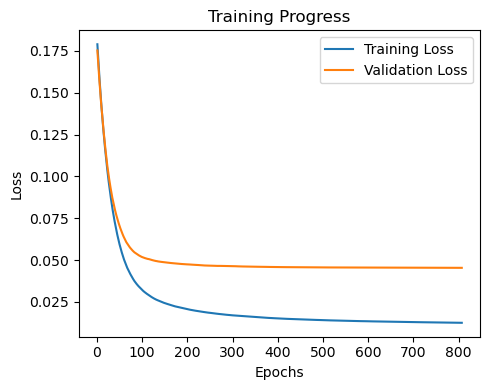

In [550]:
# Extract RMSE for train and validation
train_loss = results['validation_0']['mape']  # or 'rmse', etc.
val_loss = results['validation_1']['mape']
epochs = range(1, len(train_loss) + 1)

# Plotting
plt.figure(figsize=(5, 4))  # small and clean
plt.plot(epochs, train_loss, label='Training Loss', color='C0')
plt.plot(epochs, val_loss, label='Validation Loss', color='C1')

# Labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Progress')

# Ticks and grid
plt.xticks()
plt.yticks()
plt.grid(False)

# Legend
plt.legend( loc='upper right')

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

Evaluation

In [551]:
y_pred=model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse= np.sqrt(mse)
mae=mean_absolute_error(y_test, y_pred)
mdae=median_absolute_error(y_test, y_pred)
r2=r2_score(y_test, y_pred)
mape=mean_absolute_percentage_error(y_test, y_pred)*100
print(f"Test MSE: {mse:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test MAE: {mae:.3f}")
print(f"Test MDAE: {mdae:.3f}")
print(f"Test R2: {r2:.3f}")
print(f"Test MAPE: {mape:.3f}")

Test MSE: 0.000
Test RMSE: 0.022
Test MAE: 0.015
Test MDAE: 0.009
Test R2: 0.911
Test MAPE: 4.021


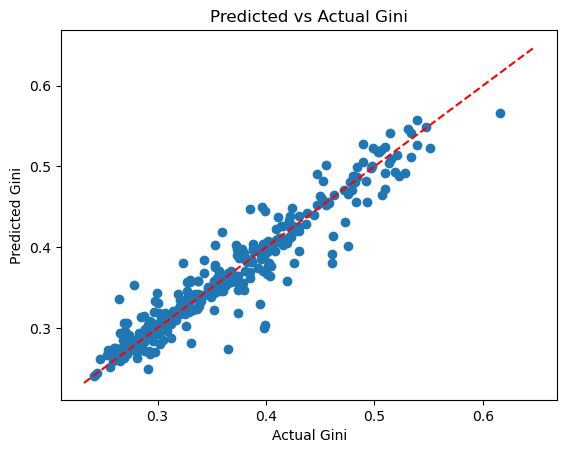

In [552]:

plt.scatter(y_test, y_pred)
plt.xlabel("Actual Gini")
plt.ylabel("Predicted Gini")
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r')
plt.title("Predicted vs Actual Gini")
plt.show()

Features with predictive relavance

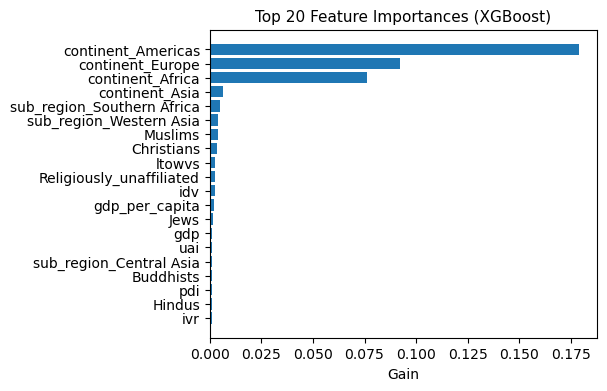

In [553]:

# Get feature names
feature_names = X.columns if hasattr(X, 'columns') else [f"f{i}" for i in range(X.shape[1])]

importances = model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importances.keys()),
    'Importance': list(importances.values())
})

# Map f0..fN -> the imputed feature names
if not importance_df.empty and importance_df['Feature'].iloc[0].startswith('f'):
    def map_f(name):
        idx = int(name[1:])
        return feature_names_imputed[idx] if idx < len(feature_names_imputed) else name
    importance_df['Feature'] = importance_df['Feature'].map(map_f)

importance_df = importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)

# Plot top N
top_n = 20
plt.figure(figsize=(5,4))
plt.barh(importance_df['Feature'].head(top_n), importance_df['Importance'].head(top_n))
plt.gca().invert_yaxis()
plt.xlabel('Gain')
plt.title(f'Top {top_n} Feature Importances (XGBoost)', fontsize=11)
plt.show()



### Evaluating on 2022 Test countries

In [555]:
X_test_countries = df_test_countries.drop(columns=['gini',"year", "country_id", "exists"])
y_test_countries = df_test_countries['gini']

In [556]:
for col in X_test_countries.columns:
    if X_test_countries[col].dtype == 'object':
        X_test_countries[col] = pd.to_numeric(X_test_countries[col], errors='coerce')

X_imputed_test_countries = imp.transform(X_test_countries)

In [557]:
X_imputed_test_countries = scaler.transform(X_imputed_test_countries)

In [558]:
y_pred_test_countries=model.predict(X_imputed_test_countries)

mse = mean_squared_error(y_test_countries, y_pred_test_countries)
rmse= np.sqrt(mse)
mae=mean_absolute_error(y_test_countries, y_pred_test_countries)
mdae=median_absolute_error(y_test_countries, y_pred_test_countries)
r2=r2_score(y_test_countries, y_pred_test_countries)
mape=mean_absolute_percentage_error(y_test_countries, y_pred_test_countries)*100
print(f"Test MSE: {mse:.3f}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test MAE: {mae:.3f}")
print(f"Test MDAE: {mdae:.3f}")
print(f"Test R2: {r2:.3f}")
print(f"Test MAPE: {mape:.3f}")

Test MSE: 0.001
Test RMSE: 0.032
Test MAE: 0.025
Test MDAE: 0.019
Test R2: 0.836
Test MAPE: 7.570


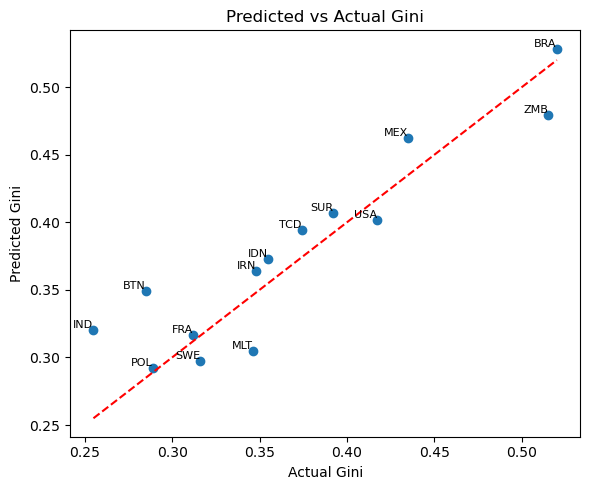

In [565]:

iso3_labels = coco.convert(df_test_countries["country_id"].tolist(),
                         src="UNnumeric", to="ISO3")

plt.figure(figsize=(6,5))

# Scatter dots
plt.scatter(y_test_countries, y_pred_test_countries, color="C0")

# Add ISO3 labels (use different loop vars!)
for x_val, y_pred_i, iso in zip(y_test_countries, y_pred_test_countries, iso3_labels):
    plt.text(x_val, y_pred_i, iso, fontsize=8, ha='right', va='bottom')

# Perfect prediction line (y = x)
plt.plot([y_test_countries.min(), y_test_countries.max()],
         [y_test_countries.min(), y_test_countries.max()],
         '--r')

plt.xlabel("Actual Gini")
plt.ylabel("Predicted Gini")
plt.title("Predicted vs Actual Gini")
plt.tight_layout()
plt.show()
